In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import numpy as np
import librosa
import librosa.display
import IPython.display
import json
import os

from src.data import NSynth, Freesound, create_audio_transform, load_audio, Normalize
from src.models import Autoencoder, VAE

/opt/conda/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
model_dir = 'train_results/vae/20200806-175812'

hparams = json.load(open(os.path.join(model_dir, 'hparams.json'), 'rb'))

weights_path = sorted([x for x in os.listdir(model_dir) if 'model' in x], key=lambda x : int(x.split('-')[-1].split('.')[0]))[-1]
weights_path = os.path.join(model_dir, weights_path)
print(weights_path)

train_results/vae/20200806-175812/model-115258.weights


In [3]:
# model = Autoencoder(h_dim=hparams['hidden_dim'], sigmoid=(not hparams['standardize']))
model =  VAE(h_dim=hparams['hidden_dim'], sigmoid=(not hparams['standardize']))
model.load_state_dict(torch.load(weights_path))
model.eval()

VAE(
  (encode): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 4), stride=(2, 2), padding=(1, 4))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2

In [4]:
transform = create_audio_transform(
    hparams['sample_rate'],
    n_samples=hparams['n_samples'],
    random_crop=False,
    feature_type=hparams['feature_type'],
    resize=hparams['resize'],
    normalize=hparams['normalize'],
    standardize=hparams['standardize'],
    standardize_mean=hparams['standardize_mean'],
    standardize_std=hparams['standardize_std'],
    spec_augment=False
)

In [5]:
nsynth = NSynth('data/nsynth', 'test')
freesound = Freesound('data/freesound', 'test')

In [9]:
audio = load_audio(nsynth.meta.iloc[10]['filename'], sample_rate=hparams['sample_rate'])
#audio = load_audio(freesound.meta.iloc[5]['fname'], sample_rate=hparams['sample_rate'])

In [10]:
features = transform(audio)
norm = [x for x in transform.transforms if type(x) == Normalize][0]

In [11]:
with torch.no_grad():
    features = features.unsqueeze(0)
    outputs, _, _ = model(features)

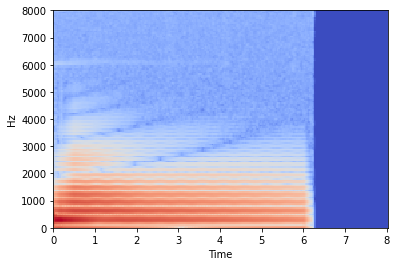

In [14]:
librosa.display.specshow(features.numpy().squeeze(), sr=16000, x_axis='time', y_axis='hz')

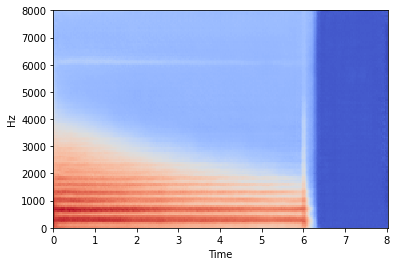

In [13]:
librosa.display.specshow(outputs.detach().numpy().squeeze(), sr=16000, x_axis='time', y_axis='hz')

In [15]:
reconstruction = (outputs * hparams['standardize_std']) + hparams['standardize_mean']
reconstruction = (reconstruction * (norm.max - norm.min)) + norm.min
reconstruction = librosa.db_to_power(reconstruction.numpy().squeeze())

sample = librosa.feature.inverse.mel_to_audio(
    reconstruction, sr=hparams['sample_rate'], n_fft=1024, hop_length=256, norm=None, htk=True
)

#### Original

In [16]:
IPython.display.Audio(audio, rate=hparams['sample_rate'])

#### Reconstructed

In [17]:
IPython.display.Audio(sample, rate=hparams['sample_rate'])